In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# will use PIL library to view image within notebook
from PIL import Image
import matplotlib.pyplot as plt

# keras tutorial: https://victorzhou.com/blog/keras-cnn-tutorial/
# also check out lecture video
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

### Overview

The histopathologic-cancer-detection dataset contains **96x96x3** pixel images. Because the depth of each input image is 3, the images must be mapped to the RBG scale. Images with a tumor tissue located in the center **32x32** frame of the image are classified as positive for having cancer; images containing tumor tissue located outside the center **32x32** frame will be classified as negative (tumor must be located in the center in order to fall in the positive class). The goal of this project is to build a Convolutional Neural Network that correctly classifies images as cancerous v. non-canerous based on the aforementioned criteria. 

I start by reading in the training labels. Note that the **train_labels.csv** only contains the image ids and the respective class label. The actual images are located in the same Kaggle folder as *{image_id}.tif* files

In [2]:
df_train = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/train_labels.csv")
print(f"{len(df_train)} samples in the training data")

220025 samples in the training data


### EDA

First I want to get a sense of how frequently occuring the positive class is in the dataset

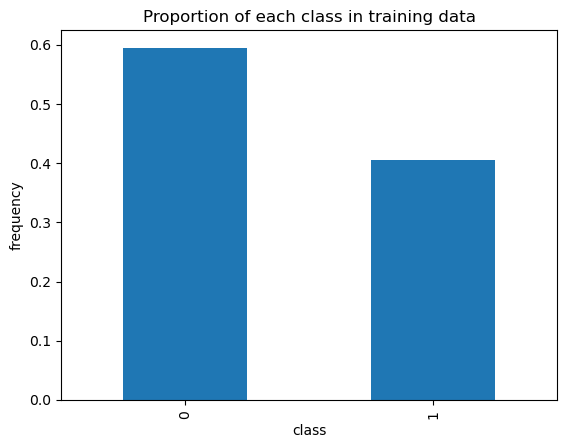

In [3]:
class_labels = df_train.label.value_counts(normalize=True)

plt.figure()
class_labels.plot(kind="bar")
plt.ylabel("frequency")
plt.xlabel("class")
plt.title("Proportion of each class in training data")
plt.show()

From the above plot we can see that the negative class appears in the dataset close to 60% of the time (meaning the positive class comprises of 40% of the data, and the baseline accuracy is 60%). This is a decently balanced dataset

Next, to get a visual comparison for cancerous images versus non-cancerous images, I am going to plot 3 random images of each class.

NON-CANEROUS IMAGES; label=0


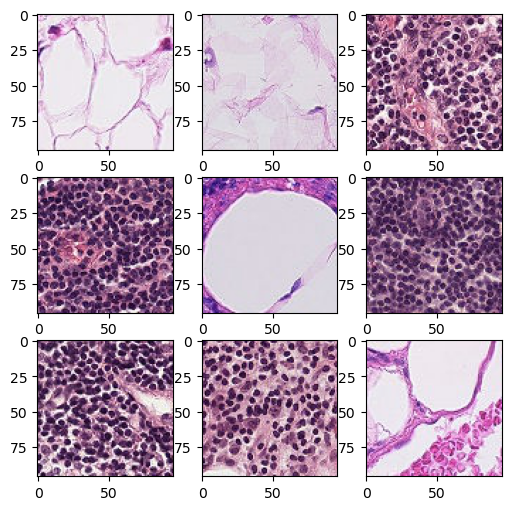

In [4]:
# nine random cancerous images
fig, ax = plt.subplots(3, 3, figsize=(6,6))
random_non_cancerous_ids = df_train[df_train.label == 0]['id'].sample(9).values

print("NON-CANEROUS IMAGES; label=0")
i = 0
for r in range(3):
    for c in range(3):
        image_path = f"/kaggle/input/histopathologic-cancer-detection/train/{random_non_cancerous_ids[i]}.tif"
        img = Image.open(image_path)
        ax[r,c].imshow(img)
        i += 1
plt.show()

CANEROUS IMAGES; label=1


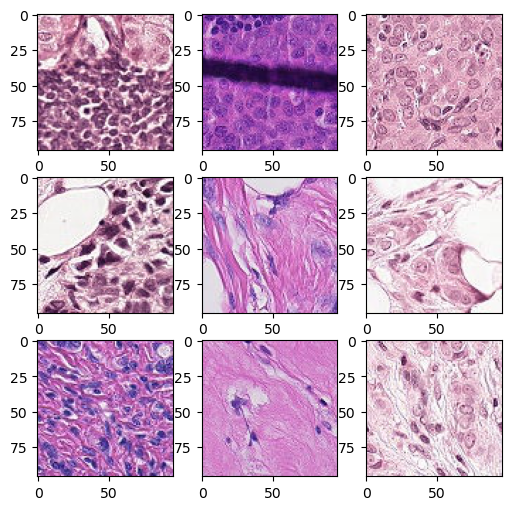

In [5]:
# nine random cancerous images
fig, ax = plt.subplots(3, 3, figsize=(6,6))
random_cancerous_ids = df_train[df_train.label == 1]['id'].sample(9).values

print("CANEROUS IMAGES; label=1")
i = 0
for r in range(3):
    for c in range(3):
        image_path = f"/kaggle/input/histopathologic-cancer-detection/train/{random_cancerous_ids[i]}.tif"
        img = Image.open(image_path)
        ax[r,c].imshow(img)
        i += 1
plt.show()

### Modeling


To model the images, I will test out various Convolutional Neural Networks each with a different architecture. The first model architecture I will test will contain the following sequential layers:
1. convolutional layer 1: 10 filters, stride=1, padding=None, filter size=3x3
2. convolutional layer 2: 5 filters, stride=1, padding=None, filter size=3x3
3. Max Pool layer: filter size=2x2, padding=None
4. Dense ANN layer with 25 neurons and a ReLU activation function
5. Dense ANN output layer with 1 neuron and sigmoid activation function


The above architecture follows the suggested architecture of 
```
[Convolution layer -> Convolution Layer -> MaxPool layer]n -> classification model -> output
```

In the case above, n=1. I will start by testing **5** epochs

In [22]:
# helper function to plot accuracy v. epochs after a model fitting
def plot_acc_vs_epochs(model_hist):
    
    n_epochs = model_hist.params['epochs']
    x = [i for i in range(1,n_epochs+1)]
    train_accuracy = model_hist.history['accuracy']
    val_accuracy = model_hist.history['val_accuracy']
    
    plt.figure(figsize=(8,5))
    plt.plot(x, train_accuracy, label="train_acc")
    plt.plot(x, val_accuracy, label="val_acc", linestyle="--", color="red")
    
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()
    plt.title("Train + Validation accuracy versus epochs")

In [20]:
n_epochs = 5
steps_per_epoch=500
cnn1 = Sequential([
        Conv2D(filters=10, strides=1, padding="valid", kernel_size=3), # padding=valid references no padding in Keras
        Conv2D(filters=5, strides=1, padding="valid", kernel_size=3), # padding=valid references no padding in Keras
        MaxPooling2D(pool_size=(2,2), strides=None, padding="valid"), #strides=None defaults to the pool size
        Flatten(),
        Dense(units=25, activation="relu"),
        Dense(units=1, activation="sigmoid"),
])
cnn1.compile("SGD", loss="binary_crossentropy", metrics=['accuracy'])

In [21]:
# ImageDataGenerator is a keras helper class that reformats images in a proper format for the neural network to accept
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_generator = ImageDataGenerator(samplewise_center=True, validation_split=.2)
df_train['image_path'] = "/kaggle/input/histopathologic-cancer-detection/train/" + df_train['id'] + ".tif"
df_train['label'] = df_train['label'].astype(str)

# from Keras documentations: flow_from_dataframe() --> Takes the dataframe and the path to a directory + generates batches.
train_generator = data_generator.flow_from_dataframe(
    dataframe=df_train,
    x_col="image_path",
    y_col="label",
    target_size=(96, 96),
    color_mode="rgb",
    class_mode="binary",
    subset="training",
    validate_filenames=False
)
val_generator = data_generator.flow_from_dataframe(
    dataframe=df_train,
    x_col="image_path",
    y_col="label",
    target_size=(96, 96),
    color_mode="rgb",
    class_mode="binary",
    subset="validation",
    validate_filenames=False
)

Found 176020 non-validated image filenames belonging to 2 classes.
Found 44005 non-validated image filenames belonging to 2 classes.


In [23]:
# steps_per_epoch determines the number of samples to iterate through in a single batch. because we used a ImageDataGenerator above,
# the data generator by default divided the training data into 32 batches, meaning there are 5501 images in a single batch (after the 80/20 split)
# we could use 5501 as the steps_per_epoch, however to cut down on training time I will start by using 1000 steps_per_epoch. this also assures that training will never
# see the same image twice, meaning the model is less likely to overfit
n_epochs = 5
steps_per_epoch=500
model_history = cnn1.fit(
    train_generator,
    epochs=n_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=steps_per_epoch,
)

Epoch 1/5
500/500 [==============================] - 193s 383ms/step - loss: nan - accuracy: 0.5932 - val_loss: nan - val_accuracy: 0.5980
Epoch 2/5
500/500 [==============================] - 189s 377ms/step - loss: nan - accuracy: 0.5930 - val_loss: nan - val_accuracy: 0.5937
Epoch 3/5
500/500 [==============================] - 180s 361ms/step - loss: nan - accuracy: 0.5926 - val_loss: nan - val_accuracy: 0.5953
Epoch 4/5
500/500 [==============================] - 177s 355ms/step - loss: nan - accuracy: 0.5988 - val_loss: nan - val_accuracy: 0.5951
Epoch 5/5
500/500 [==============================] - 141s 283ms/step - loss: nan - accuracy: 0.5968 - val_loss: nan - val_accuracy: 0.5987


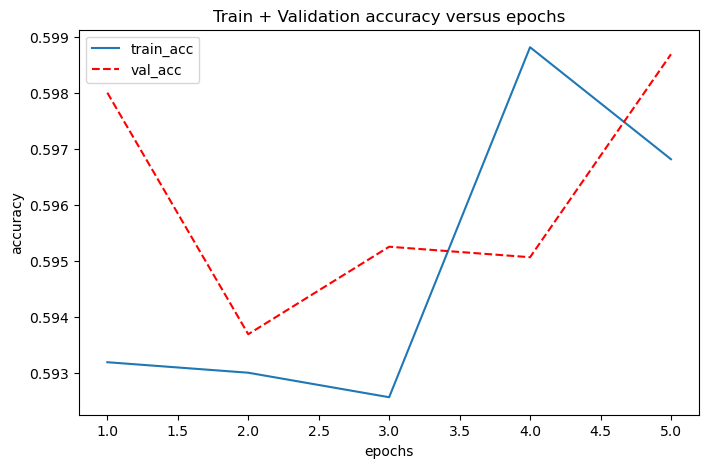

In [24]:
plot_acc_vs_epochs(model_history)

Plotting the accuracy over the course of training shows some interesting relationship between the training accuracy and validation accuracy. The fluctuation in validation accuracy shows that this is not a very stable, or well-fitted model. I can most likely get better results by changing the neural network architecture, and by training the model on more images and across more epochs.


#### Model 2


To elaborate on the past model, testing a different architecture, but more importantly I will be focusing on running more epochs to see if it has any effect on training and validation accuracy. I will use 10 epochs with 200 images per epoch. Therefore will use the same number of images as the previous model, but increase the number of epochs while decreasing the number of images per epoch. 

1. convolutional layer 1: 20 filters, stride=1, padding=None, filter size=3x3
2. convolutional layer 2: 10 filters, stride=1, padding=None, filter size=3x3
3. Max Pool layer: filter size=2x2, padding=None
4. Dense ANN output layer with 1 neuron and sigmoid activation function

I will now use 250 images per epoch, 10 epochs total. 



In [25]:
# changing the architecture of the model slighty
cnn2 = Sequential([
        Conv2D(filters=20, strides=1, padding="valid", kernel_size=3), # padding=valid references no padding in Keras
        Conv2D(filters=10, strides=1, padding="valid", kernel_size=3), # padding=valid references no padding in Keras
        MaxPooling2D(pool_size=(2,2), strides=None, padding="valid"), #strides=None defaults to the pool size
        Flatten(),
        Dense(units=1, activation="sigmoid"),
])
cnn2.compile("Adam", loss="binary_crossentropy", metrics=['accuracy'])

n_epochs = 10
steps_per_epoch=200
model_history2 = cnn2.fit(
    train_generator,
    epochs=n_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=steps_per_epoch,
)

Epoch 1/10
200/200 [==============================] - 73s 360ms/step - loss: 9.0486 - accuracy: 0.5795 - val_loss: 3.4272 - val_accuracy: 0.5886
Epoch 2/10
200/200 [==============================] - 74s 369ms/step - loss: 2.6336 - accuracy: 0.5973 - val_loss: 2.2041 - val_accuracy: 0.5930
Epoch 3/10
200/200 [==============================] - 73s 366ms/step - loss: 1.6589 - accuracy: 0.6206 - val_loss: 1.4271 - val_accuracy: 0.6403
Epoch 4/10
200/200 [==============================] - 73s 365ms/step - loss: 1.2906 - accuracy: 0.6459 - val_loss: 1.1508 - val_accuracy: 0.6672
Epoch 5/10
200/200 [==============================] - 73s 367ms/step - loss: 1.2019 - accuracy: 0.6380 - val_loss: 1.0613 - val_accuracy: 0.6541
Epoch 6/10
200/200 [==============================] - 73s 364ms/step - loss: 1.1253 - accuracy: 0.6478 - val_loss: 1.1646 - val_accuracy: 0.5987
Epoch 7/10
200/200 [==============================] - 73s 366ms/step - loss: 1.0637 - accuracy: 0.6497 - val_loss: 1.0018 - val_ac

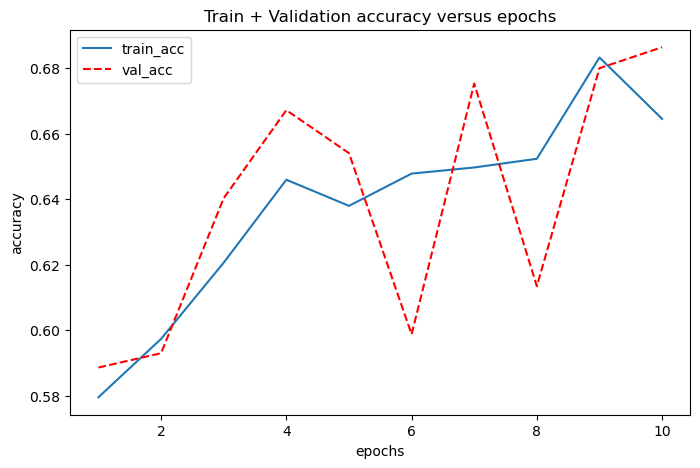

In [26]:
plot_acc_vs_epochs(model_history2)

The plot above shows that **Model 2**, trained over the same number of images but with more epochs, yielded a higher training and validation accuracy. It is still interesting that the validation accuracy fluctuates above and below the training accuracy, but promising that the training accuracy is steadily increasing throughout training. This shows that training over a higher number of epochs but with lower images per epoch yields better results than using fewer epochs with more images. 


#### Model 3

I will use the same architecture as above, but use even more images per epoch and more epochs. I also am testing out the RMSProp optimization technique opposed to using gradient descent like in the previous two models. 

In [8]:
cnn3 = Sequential([
        Conv2D(filters=32, strides=1, padding="valid", kernel_size=3), # padding=valid references no padding in Keras
        MaxPooling2D(pool_size=(2,2), strides=None, padding="valid"), #strides=None defaults to the pool size
        Conv2D(filters=32, strides=1, padding="valid", kernel_size=3), # padding=valid references no padding in Keras
        MaxPooling2D(pool_size=(2,2), strides=None, padding="valid"), #strides=None defaults to the pool size
        Flatten(),
        Dense(units=128, activation="relu"),
        Dense(units=1, activation="sigmoid"),
])
cnn3.compile("RMSProp", loss="binary_crossentropy", metrics=['accuracy'])

n_epochs = 20
steps_per_epoch = 200
model_history3 = cnn3.fit(
    train_generator,
    epochs=n_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=steps_per_epoch,
)

Epoch 1/20
200/200 [==============================] - 148s 738ms/step - loss: 17.8198 - accuracy: 0.6196 - val_loss: 0.6733 - val_accuracy: 0.5917
Epoch 2/20
200/200 [==============================] - 149s 744ms/step - loss: 0.8519 - accuracy: 0.5897 - val_loss: 0.6606 - val_accuracy: 0.5972
Epoch 3/20
200/200 [==============================] - 120s 602ms/step - loss: 1.2324 - accuracy: 0.6002 - val_loss: 2.8151 - val_accuracy: 0.5908
Epoch 4/20
200/200 [==============================] - 143s 716ms/step - loss: 0.8719 - accuracy: 0.6050 - val_loss: 0.6330 - val_accuracy: 0.7027
Epoch 5/20
200/200 [==============================] - 143s 716ms/step - loss: 0.8941 - accuracy: 0.6608 - val_loss: 0.6300 - val_accuracy: 0.6200
Epoch 6/20
200/200 [==============================] - 101s 504ms/step - loss: 0.9188 - accuracy: 0.6263 - val_loss: 0.8656 - val_accuracy: 0.7214
Epoch 7/20
200/200 [==============================] - 101s 506ms/step - loss: 1.2525 - accuracy: 0.6684 - val_loss: 0.6369 

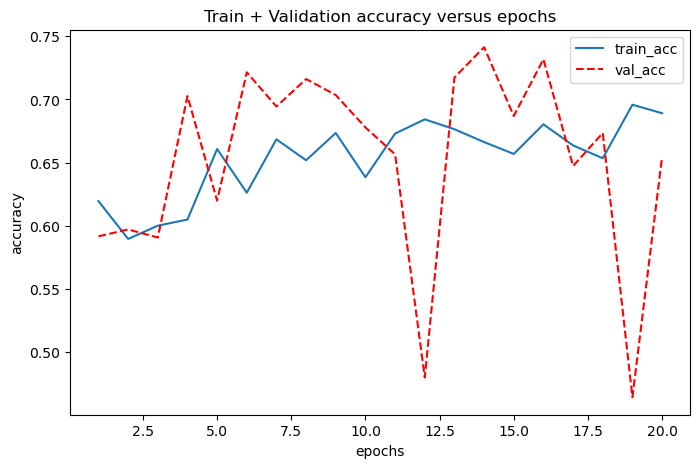

In [9]:
plot_acc_vs_epochs(model_history3)

### Conclusion


To recap, I tested out multiple Convolutional Neural Networks with the architecture `[Convolution layer -> Convolution Layer -> MaxPool layer]n -> classification model -> output`. Through tests I learned that it is better to use more epochs with fewer images per epoch, compared to using fewer epochs with more images per epoch. It was also important to use a **sigmoid** activation function as the final output layer because this is a classification problem. In the end, the model that trained over the most images per epoch with the most epochs turned out to yield the best results. It is important to note that this model also took signifacntly longer to run compared to the other models. Training time and resources must be factored into the final model decision. 

Based on this initial testing it is tough to say how much the optimization method effected the final training results. RMSProp yield a higher accuracy, but that could have been due to the increased number of epochs. I could also test out adding dropout layers in ordet to drop some of the neuron weights from the model.


### Saving test predictions

In [12]:
import os
test_path = "/kaggle/input/histopathologic-cancer-detection/test/"
df_test = pd.DataFrame({"image_id": os.listdir(test_path)})
df_test["image_path"] = test_path + df_test['image_id']

test_generator = data_generator.flow_from_dataframe(
    dataframe=df_test,
    x_col="image_path",
    y_col=None,
    target_size=(96, 96),
    color_mode="rgb",
    batch_size=64,
    shuffle=False,
    class_mode=None,
    validate_filenames=False
)

test_preds = cnn3.predict(test_generator)
test_labels = np.round(test_preds).astype(int).flatten()

df_preds = pd.DataFrame({
    "id": [i[:-4] for i in os.listdir(test_path)],
    "label": test_labels
})
df_preds.to_csv("cnn3_test_labels.csv", index=False)

Found 57458 non-validated image filenames.
898/898 [==============================] - 633s 705ms/step


In [18]:
from IPython.display import FileLink
FileLink(r'cnn3_test_labels.csv')

/kaggle/working/cnn3_test_labels.csv